In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings

warnings.filterwarnings("ignore")
import glob

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import time

In [2]:
def read_house_data(house):
    # path = '/kaggle/input/pakistan-residential-electricity-consumption/House{}.csv'.format(house)
    path = 'precon_dataset/House{}.csv'.format(house)
    df = pd.read_csv(path)
    df['Date_Time'] = df['Date_Time'].astype("datetime64[s]")
    df = df.set_index(df['Date_Time'].values)
    df.drop(['Date_Time'], axis=1, inplace=True)
    return df


df = {}
# for i in range(1,10):
#     df[i] = read_house_data(i)


# Hosue 4 and 9
df[1] = read_house_data(4)
df1_mains2 = df[1].iloc[:, 1:].sum(axis=1)
# df[1].insert(loc = 1,column = 'Sum_kW',value = df1_mains2)
df[1] = df[1][:44640]
# df[1] = df[1].reindex(sorted(df[1].columns), axis=1)

df[2] = read_house_data(9)
df2_mains2 = df[2].iloc[:, 1:].sum(axis=1)
# df[2].insert(loc = 1,column = 'Sum_kW',value = df2_mains2)
df[2] = df[2][:44640]
# df[2] = df[2].reindex(sorted(df[2].columns), axis=1)


# metadata
md = pd.read_csv('precon_dataset/Metadata.csv')

In [3]:
for i in range(1, 3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (44640, 6)


Usage_kW  AC_DR_kW  Kitchen_kW  AC_BR_kW  AC_LR_kW  \
2018-07-01 23:57:00    2.6164    0.0014      0.3019    0.0070    0.0096   
2018-07-01 23:58:00    2.6089    0.0013      0.3000    0.0070    0.0096   
2018-07-01 23:59:00    2.6033    0.0013      0.3008    0.0071    0.0097   

                     AC_MBR_kW  
2018-07-01 23:57:00     1.2559  
2018-07-01 23:58:00     1.2556  
2018-07-01 23:59:00     1.2577

House 2 data has shape:  (44640, 7)


Usage_kW  AC_LR_kW  AC_BR_kW   AC_kW  AC_kW.1  \
2018-07-01 23:57:00    0.2528    0.0006    0.0023  0.0001   0.0011   
2018-07-01 23:58:00    0.2523    0.0006    0.0023  0.0001   0.0011   
2018-07-01 23:59:00    0.2780    0.0006    0.0022  0.0001   0.0010   

                     Kitchen_kW   WP_kW  
2018-07-01 23:57:00      0.1603  0.0005  
2018-07-01 23:58:00      0.1594  0.0005  
2018-07-01 23:59:00      0.1588  0.0005

In [4]:
# House 4

md = md.drop(['Website Name', 'Ceiling_Insulation', 'Connection_Type'], axis=1)

meta_data = {}
meta_data[1] = md.iloc[4 - 1]
meta_data[2] = md.iloc[9 - 1]
# display(meta_data[1])

for i, column in enumerate(md):
    df[1].insert(i + 1, column, meta_data[1][column])
    df[2].insert(i + 1, column, meta_data[2][column])

display(df[1])
display(df[2])

Usage_kW  Property_Area_sqft  No_of_Floors  \
2018-06-01 00:00:00    3.8005             5445.01           2.0   
2018-06-01 00:01:00    3.7335             5445.01           2.0   
2018-06-01 00:02:00    3.7286             5445.01           2.0   
2018-06-01 00:03:00    3.7261             5445.01           2.0   
2018-06-01 00:04:00    3.7134             5445.01           2.0   
...                       ...                 ...           ...   
2018-07-01 23:55:00    2.7092             5445.01           2.0   
2018-07-01 23:56:00    2.6168             5445.01           2.0   
2018-07-01 23:57:00    2.6164             5445.01           2.0   
2018-07-01 23:58:00    2.6089             5445.01           2.0   
2018-07-01 23:59:00    2.6033             5445.01           2.0   

                     Building_Year  Ceiling_Height_ft  Total_No_of_Rooms  \
2018-06-01 00:00:00         2005.0               10.0                7.0   
2018-06-01 00:01:00         2005.0               10.0                7.0   
2018-06-01 00:02:00         2005.0               10.0                7.0   
2018-06-01 00:03:00         2005.0               10.0                7.0   
2018-06-01 00:04:00         2005.0               10.0                7.0   
...                            ...                ...                ...   
2018-07-01 23:55:00         2005.0               10.0                7.0   
2018-07-01 23:56:00         2005.0               10.0                7.0   
2018-07-01 23:57:00         2005.0               10.0                7.0   
2018-07-01 23:58:00         2005.0               10.0                7.0   
2018-07-01 23:59:00         2005.0               10.0                7.0   

                     Bedrooms  Livingrooms  Drawingrooms  Kitchen  ...  \
2018-06-01 00:00:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:01:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:02:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:03:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:04:00       4.0          1.0           1.0      1.0  ...   
...                       ...          ...           ...      ...  ...   
2018-07-01 23:55:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:56:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:57:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:58:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:59:00       4.0          1.0           1.0      1.0  ...   

                     No_of _Water_Pumps  No_of_Electric_Heaters  No_of_Irons  \
2018-06-01 00:00:00                 1.0                     0.0          1.0   
2018-06-01 00:01:00                 1.0                     0.0          1.0   
2018-06-01 00:02:00                 1.0                     0.0          1.0   
2018-06-01 00:03:00                 1.0                     0.0          1.0   
2018-06-01 00:04:00                 1.0                     0.0          1.0   
...                                 ...                     ...          ...   
2018-07-01 23:55:00                 1.0                     0.0          1.0   
2018-07-01 23:56:00                 1.0                     0.0          1.0   
2018-07-01 23:57:00                 1.0                     0.0          1.0   
2018-07-01 23:58:00                 1.0                     0.0          1.0   
2018-07-01 23:59:00                 1.0                     0.0          1.0   

                     No_of_Lighting_Devices  No_of_UPS  AC_DR_kW  Kitchen_kW  \
2018-06-01 00:00:00                    55.0        2.0    0.0015      0.3180   
2018-06-01 00:01:00                    55.0        2.0    0.0015      0.3176   
2018-06-01 00:02:00                    55.0        2.0    0.0015      0.3175   
2018-06-01 00:03:00                    55.0        2.0    0.0015      0.3167   
2018-06-01 00:04:00                    55.0        2.

Usage_kW  Property_Area_sqft  No_of_Floors  \
2018-06-01 00:00:00    1.4460             2722.51           2.0   
2018-06-01 00:01:00    1.4557             2722.51           2.0   
2018-06-01 00:02:00    1.4553             2722.51           2.0   
2018-06-01 00:03:00    1.4651             2722.51           2.0   
2018-06-01 00:04:00    1.4735             2722.51           2.0   
...                       ...                 ...           ...   
2018-07-01 23:55:00    0.2530             2722.51           2.0   
2018-07-01 23:56:00    0.2527             2722.51           2.0   
2018-07-01 23:57:00    0.2528             2722.51           2.0   
2018-07-01 23:58:00    0.2523             2722.51           2.0   
2018-07-01 23:59:00    0.2780             2722.51           2.0   

                     Building_Year  Ceiling_Height_ft  Total_No_of_Rooms  \
2018-06-01 00:00:00         2013.0               15.0                7.0   
2018-06-01 00:01:00         2013.0               15.0                7.0   
2018-06-01 00:02:00         2013.0               15.0                7.0   
2018-06-01 00:03:00         2013.0               15.0                7.0   
2018-06-01 00:04:00         2013.0               15.0                7.0   
...                            ...                ...                ...   
2018-07-01 23:55:00         2013.0               15.0                7.0   
2018-07-01 23:56:00         2013.0               15.0                7.0   
2018-07-01 23:57:00         2013.0               15.0                7.0   
2018-07-01 23:58:00         2013.0               15.0                7.0   
2018-07-01 23:59:00         2013.0               15.0                7.0   

                     Bedrooms  Livingrooms  Drawingrooms  Kitchen  ...  \
2018-06-01 00:00:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:01:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:02:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:03:00       4.0          1.0           1.0      1.0  ...   
2018-06-01 00:04:00       4.0          1.0           1.0      1.0  ...   
...                       ...          ...           ...      ...  ...   
2018-07-01 23:55:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:56:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:57:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:58:00       4.0          1.0           1.0      1.0  ...   
2018-07-01 23:59:00       4.0          1.0           1.0      1.0  ...   

                     No_of_Electric_Heaters  No_of_Irons  \
2018-06-01 00:00:00                     0.0          1.0   
2018-06-01 00:01:00                     0.0          1.0   
2018-06-01 00:02:00                     0.0          1.0   
2018-06-01 00:03:00                     0.0          1.0   
2018-06-01 00:04:00                     0.0          1.0   
...                                     ...          ...   
2018-07-01 23:55:00                     0.0          1.0   
2018-07-01 23:56:00                     0.0          1.0   
2018-07-01 23:57:00                     0.0          1.0   
2018-07-01 23:58:00                     0.0          1.0   
2018-07-01 23:59:00                     0.0          1.0   

                     No_of_Lighting_Devices  No_of_UPS  AC_LR_kW  AC_BR_kW  \
2018-06-01 00:00:00                    30.0        1.0    0.0005    1.0470   
2018-06-01 00:01:00                    30.0        1.0    0.0005    1.0523   
2018-06-01 00:02:00                    30.0        1.0    0.0005    1.0545   
2018-06-01 00:03:00                    30.0        1.0    0.0005    1.0520   
2018-06-01 00:04:00                    30.0        1.0    0.0005    1.0500   
...                                     ...        ...       ...       ...   
2018-07-01 23:55:00                    30.0        1.0    0.0006    0.0023   
2018-07-01 23:56:00                    30.0        1.0    0.0006    0

In [5]:
display(df[1].columns[0:28])

Index(['Usage_kW', 'Property_Area_sqft', 'No_of_Floors', 'Building_Year',
       'Ceiling_Height_ft', 'Total_No_of_Rooms', 'Bedrooms', 'Livingrooms',
       'Drawingrooms', 'Kitchen', 'No_of_People', 'Adults_14_to_60',
       'Children_0_to_13', 'Seniors', 'Permanent_Residents',
       'Temporary_Residents', 'No_of_ACs', 'No_of_Refrigerators',
       'No_of_WashingMachines', 'No_of_Electronic_Devices', 'No_of_Fans',
       'No_of_Water_Dispensers', 'No_of _Water_Pumps',
       'No_of_Electric_Heaters', 'No_of_Irons', 'No_of_Lighting_Devices',
       'No_of_UPS', 'AC_DR_kW'],
      dtype='object')

In [6]:
dates = {}
for i in range(1, 3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i, len(dates[i]), dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 31 days from 2018-06-01 to 2018-07-01.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01'] 

House 2 data contain 31 days from 2018-06-01 to 2018-07-01.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01'] 



In [7]:
df[1] = df[1].loc[:dates[1][30]]
df[2] = df[2].loc[:dates[2][30]]

print('House {} data has shape: '.format(1), df[1].shape)
print('House {} data has shape: '.format(2), df[2].shape)

House 1 data has shape:  (44640, 32)
House 2 data has shape:  (44640, 33)


Text(0.5, 1.0, 'House 2')

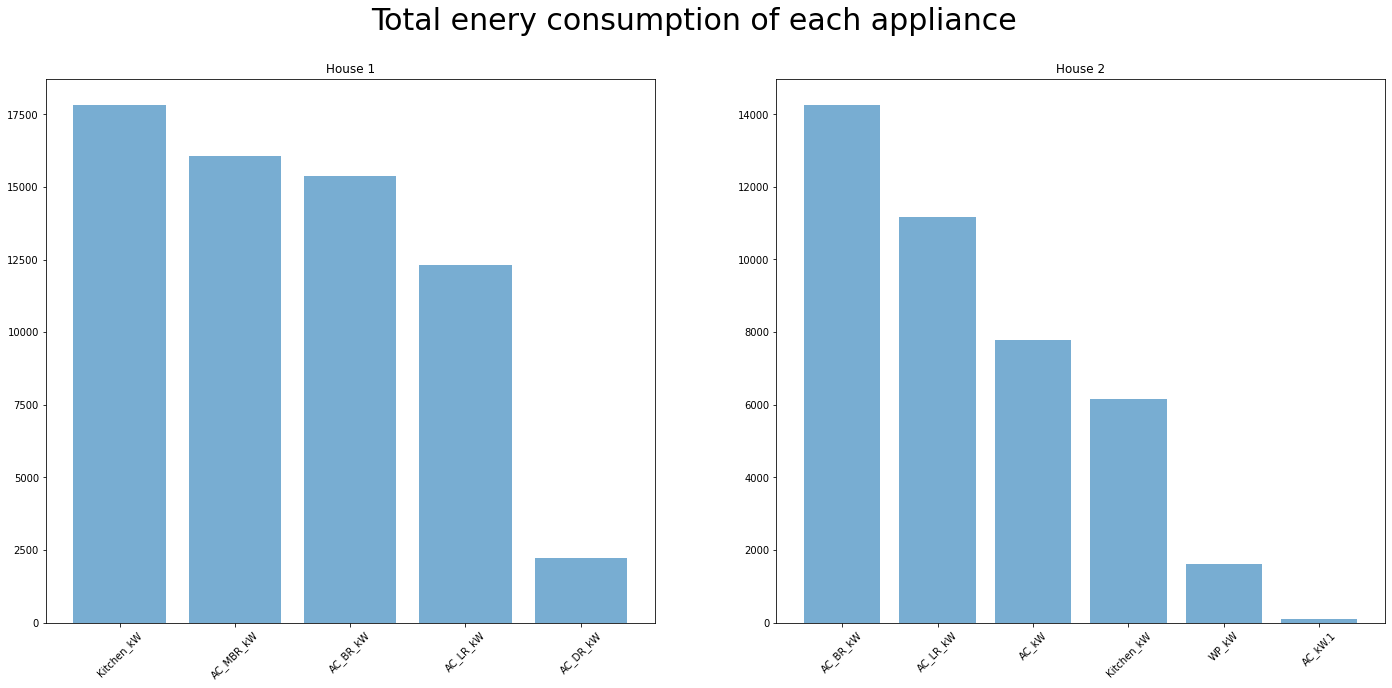

In [8]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize=30)
cons1 = df[1][df[1].drop(df[1].columns[0:27], axis=1).columns].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values, alpha=0.6)
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation=45)
plt.title('House 1')

cons2 = df[2][df[2].drop(df[2].columns[0:27], axis=1).columns.values].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation=45)
plt.title('House 2')


In [9]:
# Separating house 1 data into train, validation and test data
# df1_train = df[1].loc[:dates[1][250]]
# df1_val = df[1].loc[dates[1][251]:dates[1][325]]
# df1_test = df[1].loc[dates[1][326]:]
# print('df_train.shape: ', df1_train.shape)
# print('df_val.shape: ', df1_val.shape)
# print('df_test.shape: ', df1_test.shape)

df1_train = df[1].loc[:dates[1][15]]
df1_val = df[1].loc[dates[1][15]:dates[1][17]]
df1_test = df[1].loc[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (23040, 32)
df_val.shape:  (4320, 32)
df_test.shape:  (20160, 32)


In [14]:
def build_lstm_model(layers):
    model = Sequential()
    i = 0
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i + 1],
            #stateful=True,
            return_sequences=True if i < len(layers) - 3 else False))
        model.add(Dropout(0.3))

    model.add(Dense(layers[-1]))
    model.summary()
    return model


model = build_lstm_model([6, 64, 128, 256, 1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          18176     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [15]:
def process_data(df, dates, x_features, y_features, look_back=50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i + look_back]
                      for i in range(len_data - look_back)]).reshape(-1, look_back, 6)
        y = data[y_features].values[look_back:, :]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X, Y

In [16]:
start = time.time()
# X_train, y_train = process_data(df[1], dates[1][:17], df[1].columns[0:27], ['Kitchen_kW'])
X_train, y_train = process_data(df[1], dates[1][:17], ['Usage_kW','Total_No_of_Rooms','Bedrooms','Livingrooms','Drawingrooms','Kitchen'], ['Kitchen_kW'])
X_test, y_test = process_data(df[1], dates[1][17:], ['Usage_kW','Total_No_of_Rooms','Bedrooms','Livingrooms','Drawingrooms','Kitchen'], ['Kitchen_kW'])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  21.332979440689087
(23630, 50, 6) (23630, 1) (19460, 50, 6) (19460, 1)


In [17]:
print(df[1].columns.values[27:])

['AC_DR_kW' 'Kitchen_kW' 'AC_BR_kW' 'AC_LR_kW' 'AC_MBR_kW']


In [23]:
start = time.time()
adam = Adam(lr=5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model_md.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
    X_train,
    y_train,
    batch_size=512,
    verbose=1,
    epochs=200,
    validation_split=0.3,
    callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
33/33 [==============================] - 102s 3s/step - loss: 0.0197 - val_loss: 0.0164
Epoch 2/200
33/33 [==============================] - 95s 3s/step - loss: 0.0186 - val_loss: 0.0164
Epoch 3/200
33/33 [==============================] - 95s 3s/step - loss: 0.0179 - val_loss: 0.0163
Epoch 4/200
33/33 [==============================] - 95s 3s/step - loss: 0.0173 - val_loss: 0.0160
Epoch 5/200
33/33 [==============================] - 95s 3s/step - loss: 0.0169 - val_loss: 0.0160
Epoch 6/200
33/33 [==============================] - 96s 3s/step - loss: 0.0165 - val_loss: 0.0159
Epoch 7/200
33/33 [==============================] - 95s 3s/step - loss: 0.0163 - val_loss: 0.0157
Epoch 8/200
33/33 [==============================] - 95s 3s/step - loss: 0.0162 - val_loss: 0.0156
Epoch 9/200
33/33 [==============================] - 95s 3s/step - loss: 0.0159 - val_loss: 0.0156
Epoch 10/200
33/33 [==============================] - 95s 3s/step - loss: 0.0158 - val_loss: 0.0155
Epoch 11

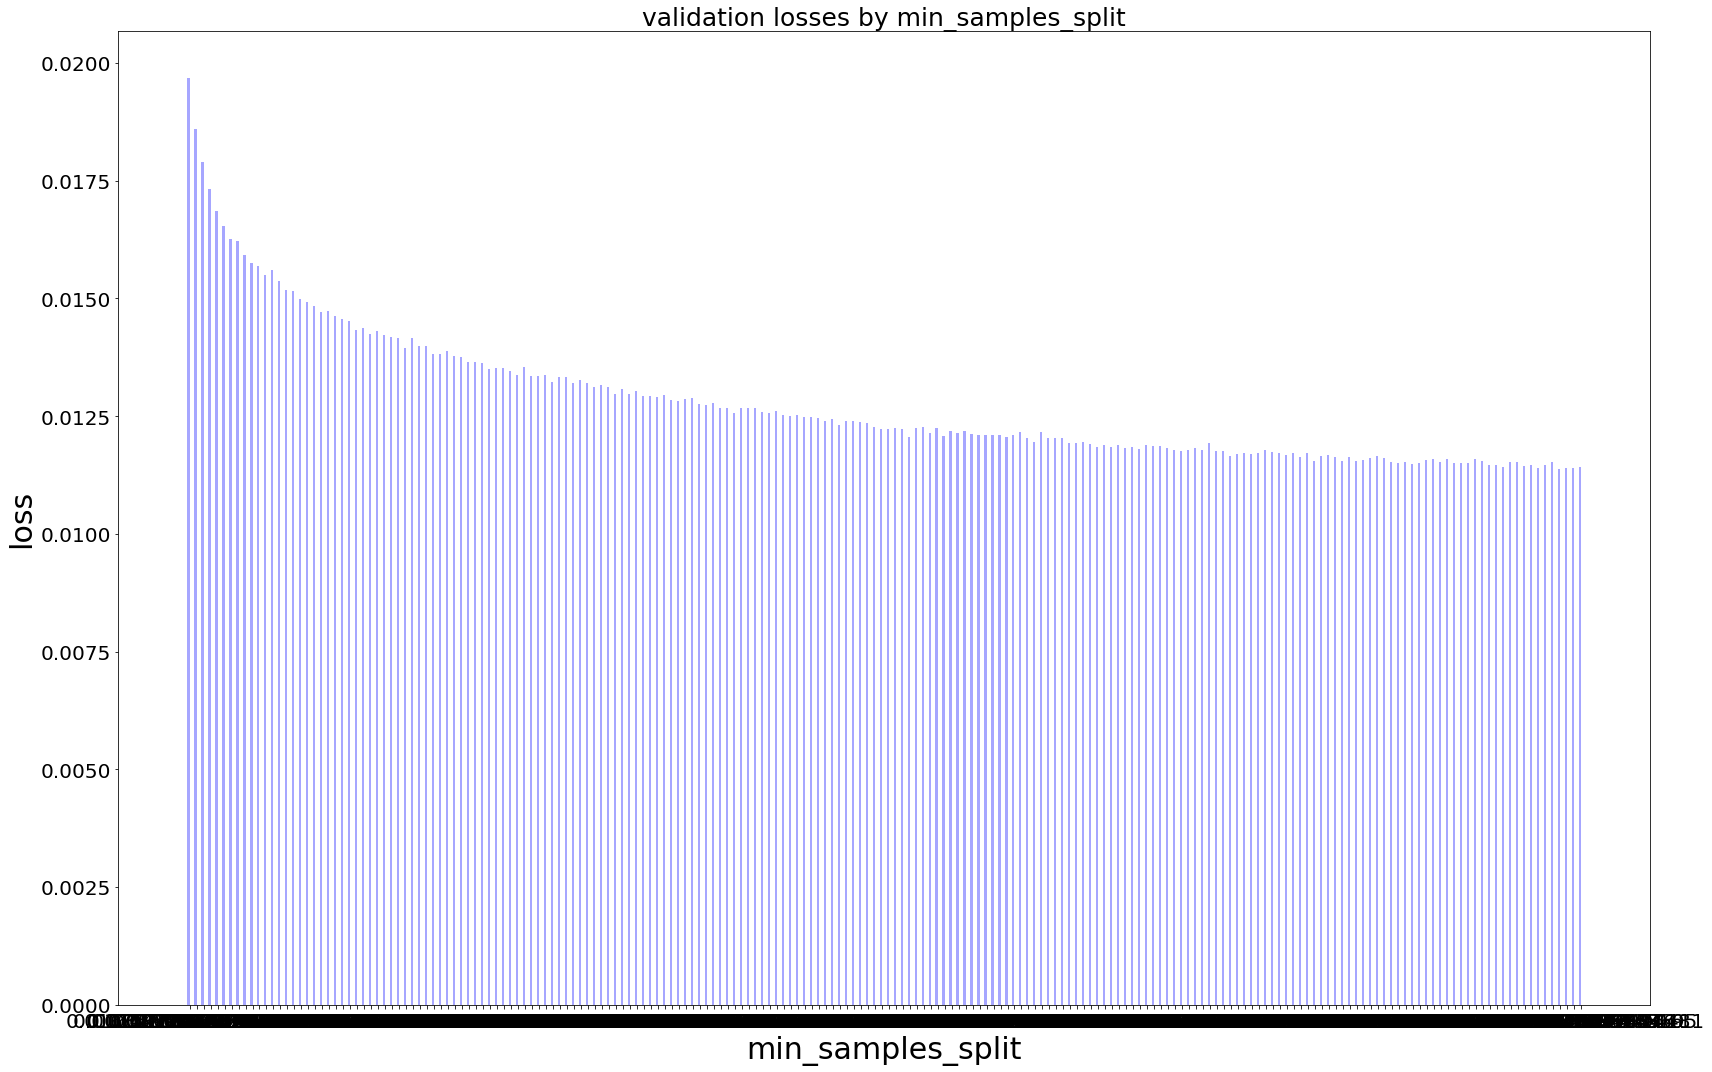

In [24]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.3
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize='25')
    plt.xticks(index + bar_width / 2, min_samples_split, fontsize=20)
    plt.yticks(fontsize=20)
    plt.rcParams["figure.figsize"] = [24, 15]
    plt.tight_layout()


train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [25]:
model = load_model('lstm_model_md.hdf5')
# model = load_model('lstm_model_md.hdf5')
# model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)


(19460,)


In [21]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y))


def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))


mse_loss_lstm = mse_loss(pred_lstm, y_test)
mae_loss_lstm = mae_loss(pred_lstm, y_test)
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  0.02473070910695086
Mean absolute error on the test set:  0.12699722081762063


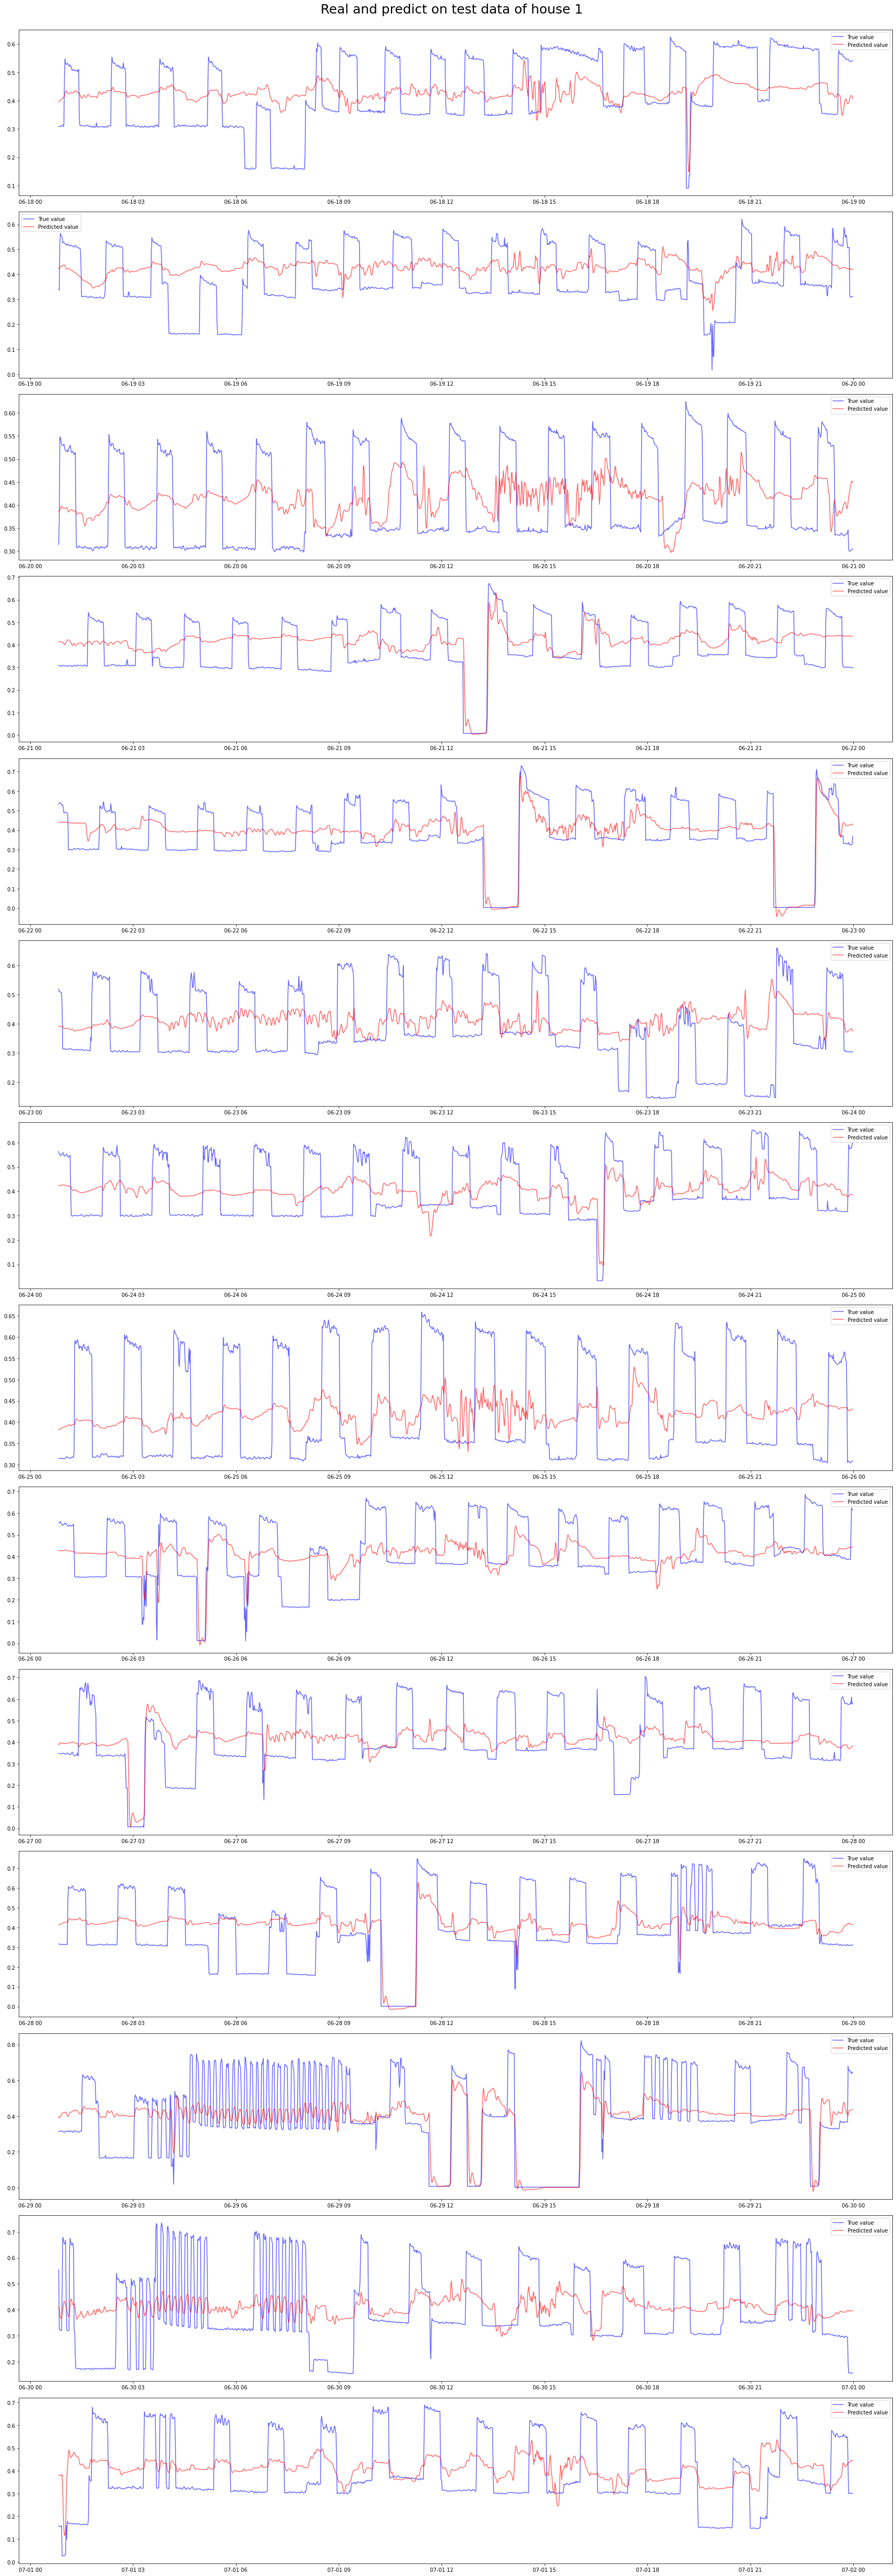

In [26]:
def plot_each_app(df, dates, predict, y_test, title, look_back=0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date, 1, figsize=(24, num_date * 5))
    plt.suptitle(title, fontsize='25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.97)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        display()
        axes.flat[i].plot(ind, y_test[l:l + len(ind)], color='blue', alpha=0.6, label='True value')
        axes.flat[i].plot(ind, predict[l:l + len(ind)], color='red', alpha=0.6, label='Predicted value')
        axes.flat[i].legend()
        l = l + len(ind)


plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test,
              'Real and predict on test data of house 1', look_back=50)

### Test LST model on house 2

In [27]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW','Total_No_of_Rooms','Bedrooms','Livingrooms','Drawingrooms','Kitchen'], ['Kitchen_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

Process data time:  19.027851581573486
(43090,)


In [28]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.046629619118015636
Mean absolute error on the test set:  0.1734891053174182


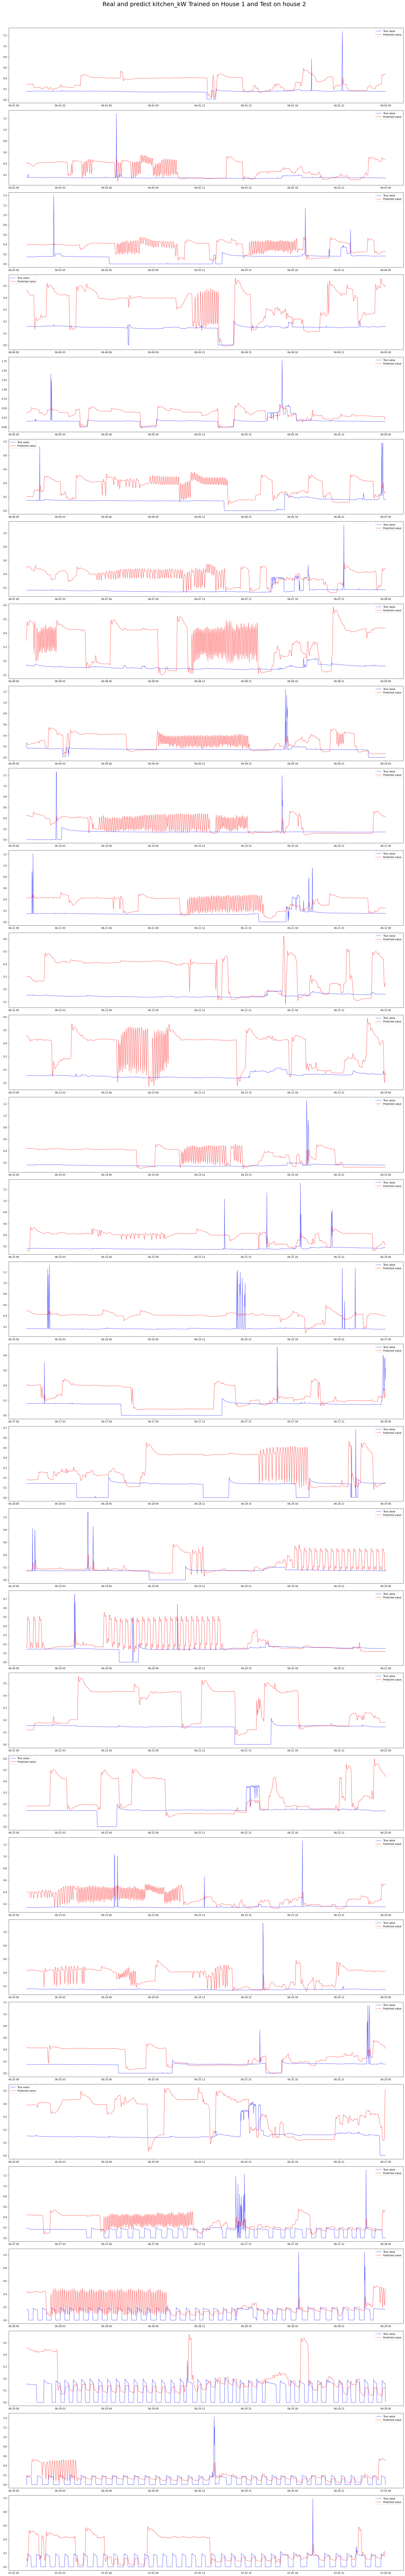

In [29]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=50)

Real and Predicted Data for All Appliences Train on House 1 and Tested on Hosue 2

In [90]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW'], ['UPS_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

Process data time:  18.98403000831604
(43090, 1)
Process data time:  18.3519229888916
(43090,)


In [92]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
print(pred_lstm_h2.shape)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.016515076999271027
Mean absolute error on the test set:  0.09782079693195483
(43090,)
Mean square error on test set:  0.016515076999271027
Mean absolute error on the test set:  0.09782079693195483


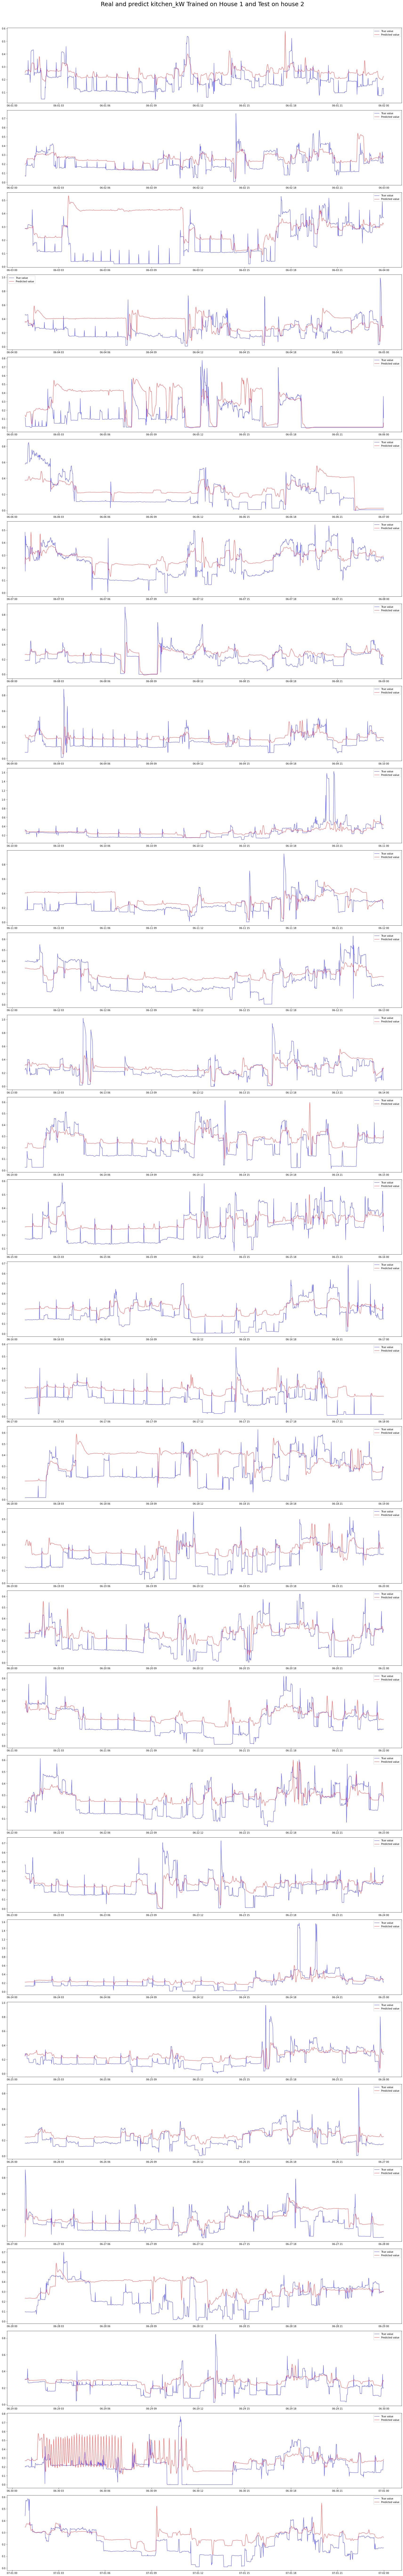

In [93]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back=50)

Process data time:  17.385003805160522
(43090,)
(43090,)
Mean square error on test set:  0.11433618119808607
Mean absolute error on the test set:  0.286646902711191


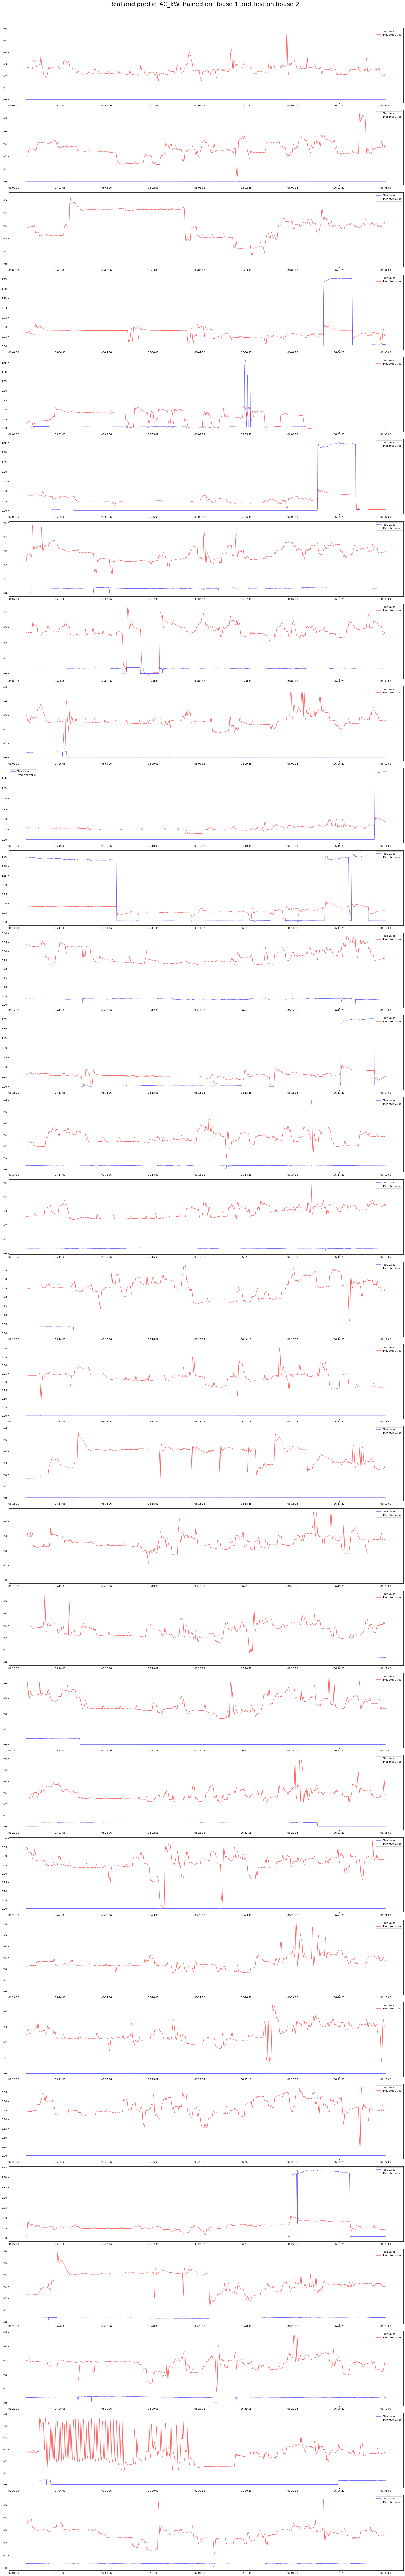

In [94]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW'], ['AC_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

pred_lstm_h2 = model.predict(X_2).reshape(-1)
print(pred_lstm_h2.shape)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict AC_kW Trained on House 1 and Test on house 2', look_back=50)